1 - Importação das bibliotecas

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

2 - Carregamento e inspeção inicial dos dados


In [2]:
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
tcc_df = pd.read_csv(url)
print("Shape do dataset:", tcc_df.shape)
display(tcc_df.head())
print("\nInformações do dataset:")
tcc_df.info()
print("\nDistribuição da variável alvo (Churn):")
tcc_df['Churn'].value_counts(normalize=True)

Shape do dataset: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling 

,proportion
Churn,
No,0.73463
Yes,0.26537


3 - Limpeza e tratamento dos dados

In [3]:
tcc_df.replace(" ", np.nan, inplace=True)
missing = tcc_df.isnull().sum()
print("\nDados faltantes por coluna:")
print(missing[missing > 0])
tcc_df.dropna(inplace=True)
print("\nShape após remoção de dados faltantes:", tcc_df.shape)


Dados faltantes por coluna:
TotalCharges    11
dtype: int64

Shape após remoção de dados faltantes: (7032, 21)


4 - Codificação das variáveis categóricas

In [4]:
cat_cols = tcc_df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('customerID')
cat_cols.remove('Churn')

le = LabelEncoder()
for col in cat_cols:
    tcc_df[col] = le.fit_transform(tcc_df[col])
tcc_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,2504,No
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1465,No
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,156,Yes
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1399,No
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,924,Yes


5 - Definição das features e target

In [5]:
X = tcc_df.drop(['customerID', 'Churn'], axis=1)
y = tcc_df['Churn'].map({'No': 0, 'Yes': 1})

print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

Shape de X: (7032, 19)
Shape de y: (7032,)


6- Divisão entre treino e teste

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Tamanho treino: {X_train.shape[0]} amostras")
print(f"Tamanho teste: {X_test.shape[0]} amostras")


Tamanho treino: 4922 amostras
Tamanho teste: 2110 amostras


7 - Normalização dos dados


In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

8 - Treinamento do modelo base - Regressão Logística

In [8]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1549
           1       0.65      0.54      0.59       561

    accuracy                           0.80      2110
   macro avg       0.74      0.72      0.73      2110
weighted avg       0.79      0.80      0.79      2110

Confusion Matrix:
 [[1384  165]
 [ 260  301]]
ROC AUC Score: 0.8345


9 - Ajuste do threshold para melhorar recall

In [10]:
threshold = 0.3
y_pred_adj = np.where(y_proba >= threshold, 1, 0)

print(classification_report(y_test, y_pred_adj))
print(confusion_matrix(y_test, y_pred_adj))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1549
           1       0.52      0.76      0.62       561

    accuracy                           0.75      2110
   macro avg       0.71      0.75      0.71      2110
weighted avg       0.79      0.75      0.76      2110

[[1154  395]
 [ 136  425]]
ROC AUC Score: 0.8345


10 - Balanceamento dos dados com SMOTE

In [12]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("Shape após SMOTE:", X_train_res.shape, y_train_res.shape)

Shape após SMOTE: (7228, 19) (7228,)


11 - Treinamento e avaliação com dados balanceados

In [15]:
model_bal = LogisticRegression(max_iter=1000, random_state=42)
model_bal.fit(X_train_res, y_train_res)

y_pred_bal = model_bal.predict(X_test_scaled)
y_proba_bal = model_bal.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_bal))

              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1549
           1       0.51      0.77      0.61       561

    accuracy                           0.74      2110
   macro avg       0.70      0.75      0.71      2110
weighted avg       0.79      0.74      0.75      2110



12 - Treinamento e avaliação do Random Forest

In [16]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1549
           1       0.60      0.46      0.52       561

    accuracy                           0.77      2110
   macro avg       0.71      0.67      0.69      2110
weighted avg       0.76      0.77      0.76      2110



13 - Visualização dos resultados com gráficos

In [17]:
def plot_roc_curve(y_true, y_proba, label=None):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Curva ROC')
    plt.legend()

In [18]:
def plot_precision_recall_curve(y_true, y_proba, label=None):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva Precision-Recall')
    plt.legend()


In [19]:
def plot_confusion_matrix(y_true, y_pred, label=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusão {label}')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()


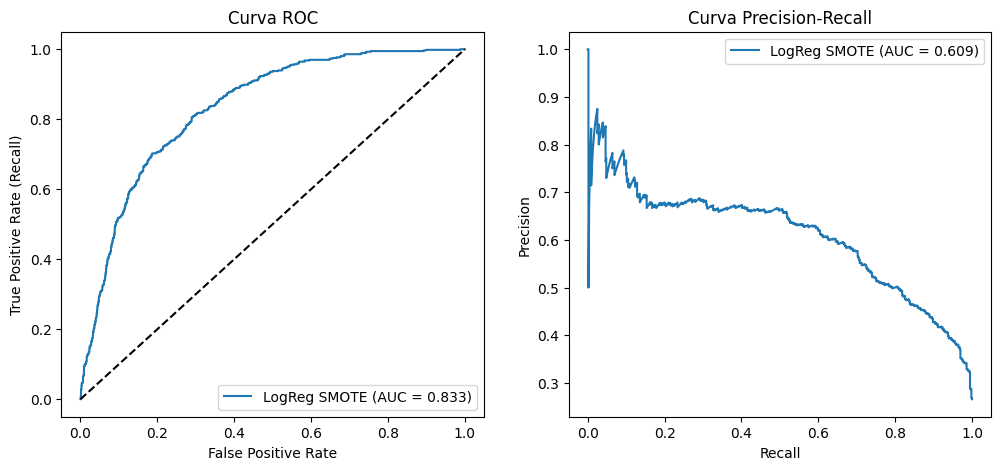

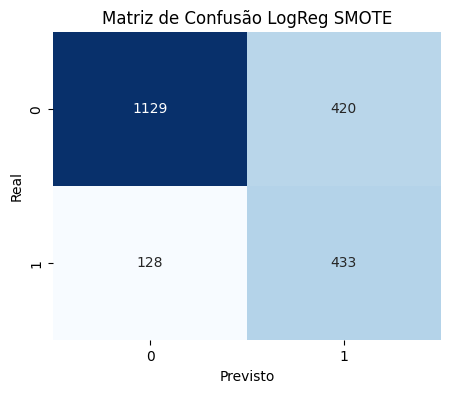

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_roc_curve(y_test, y_proba_bal, label='LogReg SMOTE')

plt.subplot(1, 2, 2)
plot_precision_recall_curve(y_test, y_proba_bal, label='LogReg SMOTE')
plt.show()

plot_confusion_matrix(y_test, y_pred_bal, label='LogReg SMOTE')

1. Curva ROC (primeira imagem)
A curva ROC mostra a relação entre False Positive Rate (eixo X) e True Positive Rate (recall, eixo Y).

A linha tracejada é o baseline (modelo aleatório).

A curva do seu modelo fica bem acima da linha diagonal, indicando boa capacidade de discriminação.

O AUC de 0.833 confirma que seu modelo tem desempenho sólido para separar churners e não churners.

2. Curva Precision-Recall (segunda imagem)
Essa curva é muito útil para problemas com classes desbalanceadas, como churn.

O gráfico mostra como a precisão varia com o recall para diferentes thresholds.

Você tem um recall alto, mas a precisão vai caindo conforme tenta capturar mais churners, mostrando o trade-off clássico.

O AUC de 0.609 indica que, apesar do bom recall, a precisão sofre uma queda — é esperado, pois o modelo tenta detectar o máximo possível de churners, aceitando alguns falsos positivos.

3. Matriz de Confusão (terceira imagem)
Os valores são:

1129 verdadeiros negativos (cliente corretamente classificado como não churn)

420 falsos positivos (clientes classificados como churn, mas que não são)

128 falsos negativos (clientes churn não detectados — aqui o ideal é minimizar)

433 verdadeiros positivos (clientes churn corretamente identificados)

O modelo apresenta um bom número de verdadeiros positivos, indicando que está capturando uma parte significativa dos churners.

Porém, o número de falsos positivos (420) é relativamente alto — é o preço do maior recall.

A quantidade de falsos negativos (128) é menor, o que é positivo para retenção, já que menos clientes em risco passam despercebidos.